In [1]:
import pandas as pd
import numpy as np
import itertools
import warnings
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering, KMeans, OPTICS

import pyPLNmodels
from pyPLNmodels.models import PlnPCAcollection, Pln, ZIPln

import predictive_plots,predictive_clustering,utils


#### Importing scales data

In [2]:
warnings.filterwarnings('ignore', category=FutureWarning)

scales_BEBRASK = pd.read_excel("../Datasets/RETOS_scales.xlsx")
scales_RETOS = pd.read_excel("../Datasets/BEBRASK_scales.xlsx")
scales = pd.concat([scales_BEBRASK, scales_RETOS])
scales = scales.query("EPRIME_CODE != 'PREDWELL_RETOS-307-1'")
cols = scales.columns
#We convert all data to numeric, and change to NaN those values that can not be converted
scales[cols[3:]] = scales[cols[3:]].apply(pd.to_numeric, errors='coerce') 
scales.reset_index(drop=True,inplace=True)
nan_counts = scales.isna().sum()

# Identify columns where the count of NaN is less than or equal to 50
columns_with_fewer_nans = nan_counts[nan_counts <= 50].index.tolist()

# Filter the DataFrame to include only these columns
scales = scales[columns_with_fewer_nans]

In [3]:
#Now we fill the NaN values
scales.isna().sum()
scales["UPPSP_PMD"].fillna(value=scales["UPPSP_PMD"].mean(),inplace=True)
scales["ASI_P"].fillna(value=scales["ASI_P"].mean(),inplace=True)
scales["ASI_C"].fillna(value=scales["ASI_C"].mean(),inplace=True)


In [4]:
aux = scales.drop(["SUBJECT_CODE","EPRIME_CODE","Age","SPQ","SPQ_IR","MSSB_POS","MSSB_NEG","MSSB_DES"],axis=1)


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.linear_model import LinearRegression,Lasso

aux = scales.drop(["SUBJECT_CODE","EPRIME_CODE","Age","SPQ","SPQ_IR","MSSB_POS","MSSB_NEG","MSSB_DES"],axis=1)

#Since there are plenty of missing values, we will use a regression approach to fill these values
variables = ['SPQ','SPQ_IR','MSSB_POS','MSSB_NEG','MSSB_DES']
#Non NaN for SPQ
for var in variables:
    # Filter for non-NaN rows for the current variable
    X = aux[scales[var].notna()]
    y = scales.loc[X.index][var]
    
    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=30, train_size=len(X)-30, random_state=42)

    # Initialize and train the model
    model = RandomForestRegressor(n_estimators=1000,criterion="absolute_error",max_features ="sqrt",min_samples_split=15)
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Calculate RMSE for test predictions
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    print(f"Test RMSE for {var}: {rmse}")
    
    mean_value = y_train.mean()

    # Create a list of 30 repeated values of the mean
    repeated_means = [mean_value] * 30
    rmse = sqrt(mean_squared_error(y_test, repeated_means))
    print(f"Means RMSE for {var}: {rmse}")
    # Predict missing values
    var_NA = aux[scales[var].isna()]
    pred_var = np.round(model.predict(var_NA))

    # Convert predictions to a pandas Series with an index matching that of var_NA
    pred_var_series = pd.Series(pred_var, index=var_NA.index)

    # Assign the predicted values back into the original 'scales' DataFrame
    scales.loc[pred_var_series.index, var] = pred_var_series

Test RMSE for SPQ: 1.451166324030433
Means RMSE for SPQ: 1.5933891203622828
Test RMSE for SPQ_IR: 1.4219890412142189
Means RMSE for SPQ_IR: 1.5087298045135171
Test RMSE for MSSB_POS: 1.8267691698734132
Means RMSE for MSSB_POS: 1.7888543819998317
Test RMSE for MSSB_NEG: 2.3090335063253917
Means RMSE for MSSB_NEG: 2.3897931105246557
Test RMSE for MSSB_DES: 2.047701054434786
Means RMSE for MSSB_DES: 2.5841396591085743


In [6]:
#Grouping the metrics that will be evaluated from scales for the BEBRASK and RETOS dataset (as the rest were no used
#or contain to many NaNs
PANAS = ["PA", "NA."]
ERQ = ["ERQ_CR", "ERQ_ES"]
UPPSP = ["UPPSP_NU", "UPPSP_PU", "UPPSP_SS", "UPPSP_PMD", "UPPSP_PSV"]
BIS_BAS = ["BIS", "BAS_D", "BAS_RR", "BAS_FS"]
TEPS = ["TEPS_AF", "TEPS_CF"]
SHS = ["SHS"]
FS = ["FS"]
LOTR = ["LOT_R"]
RRQ = ["RRQ_Rum", "RRQ_Ref"]
ASI3 = ["ASI_P", "ASI_C", "ASI_S"]
SPQ = ["SPQ", "SPQ_IR"]
MSSB = ["MSSB_POS", "MSSB_NEG", "MSSB_DES"]

list_metrics = [PANAS, ERQ, UPPSP, BIS_BAS, TEPS, SHS, FS, LOTR, RRQ, ASI3, SPQ, MSSB]

#### Importing the TimeSeries Dataset to use it for analysis later on

In [7]:
ts_data = pd.read_excel("RETOS_BEBRASK_Rating0_Time_Series.xlsx")
ts_data.sort_values(by='Subject ID').reset_index(drop=True)


,Subject ID,Happy_0_0,Happy_0_1,Happy_0_2,Happy_0_3,Happy_0_4,Happy_0_5,Happy_1_0,Happy_1_1,Happy_1_2,...,Fear_0_5,Fear_1_0,Fear_1_1,Fear_1_2,Fear_1_3,Fear_1_4,Fear_1_5,Fear_1_6,Fear_1_7,Fear_1_8
0,PREDWELL_RETOS-1-1,4,1,1,1,1,1,4,4,4,...,2,4,2,2,4,4,3,4,2,4
1,PREDWELL_RETOS-10-1,2,1,1,2,1,1,4,4,3,...,3,3,4,3,3,4,1,4,4,2
2,PREDWELL_RETOS-1001-1,4,1,1,1,1,1,4,4,4,...,3,4,1,3,2,3,4,3,3,4
3,PREDWELL_RETOS-1002-1,1,1,3,1,1,1,3,4,4,...,1,3,1,3,4,3,4,2,3,4
4,PREDWELL_RETOS-1003-1,1,1,1,1,1,1,3,3,4,...,2,2,2,3,2,2,2,1,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,PREDWELL_RETOS-5-1,2,2,1,1,1,1,3,4,4,...,1,1,1,4,2,4,3,3,2,2
145,PREDWELL_RETOS-6-1,1,2,1,1,1,1,3,3,4,...,1,2,2,2,4,2,3,2,4,4
146,PREDWELL_RETOS-7-1,1,1,1,1,1,1,3,4,2,...,4,4,1,2,4,4,1,4,4,1
147,PREDWELL_RETOS-8-1,1,1,1,1,1,1,4,4,1,...,3,3,3,4,3,2,4,2,1,3


In [8]:
mean_data = ts_data["Subject ID"].copy()
mean_data = pd.DataFrame(mean_data)
# Calculate mean scores for 'No Match' and 'Match' conditions for each emotion
mean_data['Happy_No_Match'] = ts_data[
    ['Happy_0_0', 'Happy_0_1', 'Happy_0_2', 'Happy_0_3', 'Happy_0_4', 'Happy_0_5']].mean(axis=1)
mean_data['Happy_Match'] = ts_data[
    ['Happy_1_0', 'Happy_1_1', 'Happy_1_2', 'Happy_1_3', 'Happy_1_4', 'Happy_1_5', 'Happy_1_6', 'Happy_1_7',
     'Happy_1_8']].mean(axis=1)

# Repeat for 'Sad' and 'Fear' emotions
mean_data['Sad_No_Match'] = ts_data[['Sad_0_0', 'Sad_0_1', 'Sad_0_2', 'Sad_0_3', 'Sad_0_4', 'Sad_0_5']].mean(axis=1)
mean_data['Sad_Match'] = ts_data[
    ['Sad_1_0', 'Sad_1_1', 'Sad_1_2', 'Sad_1_3', 'Sad_1_4', 'Sad_1_5', 'Sad_1_6', 'Sad_1_7', 'Sad_1_8']].mean(axis=1)

mean_data['Fear_No_Match'] = ts_data[
    ['Fear_0_0', 'Fear_0_1', 'Fear_0_2', 'Fear_0_3', 'Fear_0_4', 'Fear_0_5']].mean(axis=1)
mean_data['Fear_Match'] = ts_data[
    ['Fear_1_0', 'Fear_1_1', 'Fear_1_2', 'Fear_1_3', 'Fear_1_4', 'Fear_1_5', 'Fear_1_6', 'Fear_1_7',
     'Fear_1_8']].mean(axis=1)
mean_data  = mean_data.sort_values(by = "Subject ID").reset_index(drop=True)

In [9]:
mean_data

,Subject ID,Happy_No_Match,Happy_Match,Sad_No_Match,Sad_Match,Fear_No_Match,Fear_Match
0,PREDWELL_RETOS-1-1,1.500000,3.888889,2.166667,3.555556,2.000000,3.222222
1,PREDWELL_RETOS-10-1,1.333333,3.333333,1.833333,2.555556,2.333333,3.111111
2,PREDWELL_RETOS-1001-1,1.500000,3.888889,1.666667,2.888889,2.000000,3.000000
3,PREDWELL_RETOS-1002-1,1.333333,3.777778,2.000000,3.000000,2.333333,3.000000
4,PREDWELL_RETOS-1003-1,1.000000,3.333333,1.333333,2.777778,1.666667,2.222222
...,...,...,...,...,...,...,...
144,PREDWELL_RETOS-5-1,1.333333,3.000000,1.666667,3.222222,1.833333,2.444444
145,PREDWELL_RETOS-6-1,1.166667,3.222222,1.500000,2.222222,2.000000,2.777778
146,PREDWELL_RETOS-7-1,1.000000,3.222222,1.833333,3.000000,2.000000,2.777778
147,PREDWELL_RETOS-8-1,1.000000,3.111111,2.000000,3.111111,2.666667,2.777778


In [10]:
Happy = ["Happy_No_Match", "Happy_Match"]
Sad = ["Sad_No_Match", "Sad_Match"]
Fear = ["Fear_No_Match", "Fear_Match"]
Avg_Rating = ["Mean_Rating0"]
Correlation = ["Cor_Pred_Like"]
Dif_Match = ["Dif_Match"]

list_emotions = [Happy,Sad,Fear,Avg_Rating,Correlation,Dif_Match]

## Prediction on Rating0 on RETOS & BEBRASK on the Baselina Dataset


In [11]:
baseline = pd.read_excel("RETOS_BEBRASK_Baseline.xlsx")
baseline

,Subject,Mean_Rating0,Dif_Match,Cor_Pred_Like
0,PREDWELL_RETOS-1-1,2.888889,1.614379,0.113495
1,PREDWELL_RETOS-10-1,2.533333,1.117647,0.214781
2,PREDWELL_RETOS-1001-1,2.644444,1.494553,0.336312
3,PREDWELL_RETOS-1002-1,2.711111,1.318083,0.450822
4,PREDWELL_RETOS-1003-1,2.200000,1.424837,0.073526
...,...,...,...,...
144,PREDWELL_RETOS-5-1,2.377778,1.300654,0.225374
145,PREDWELL_RETOS-6-1,2.266667,1.152505,0.499722
146,PREDWELL_RETOS-7-1,2.444444,1.352941,0.426911
147,PREDWELL_RETOS-8-1,2.555556,1.117647,0.186173


In [12]:
mean_data["Mean_Rating0"] = baseline["Mean_Rating0"]
mean_data["Dif_Match"] = baseline["Dif_Match"]
mean_data["Cor_Pred_Like"] = baseline["Cor_Pred_Like"]

#### Distribution of variables

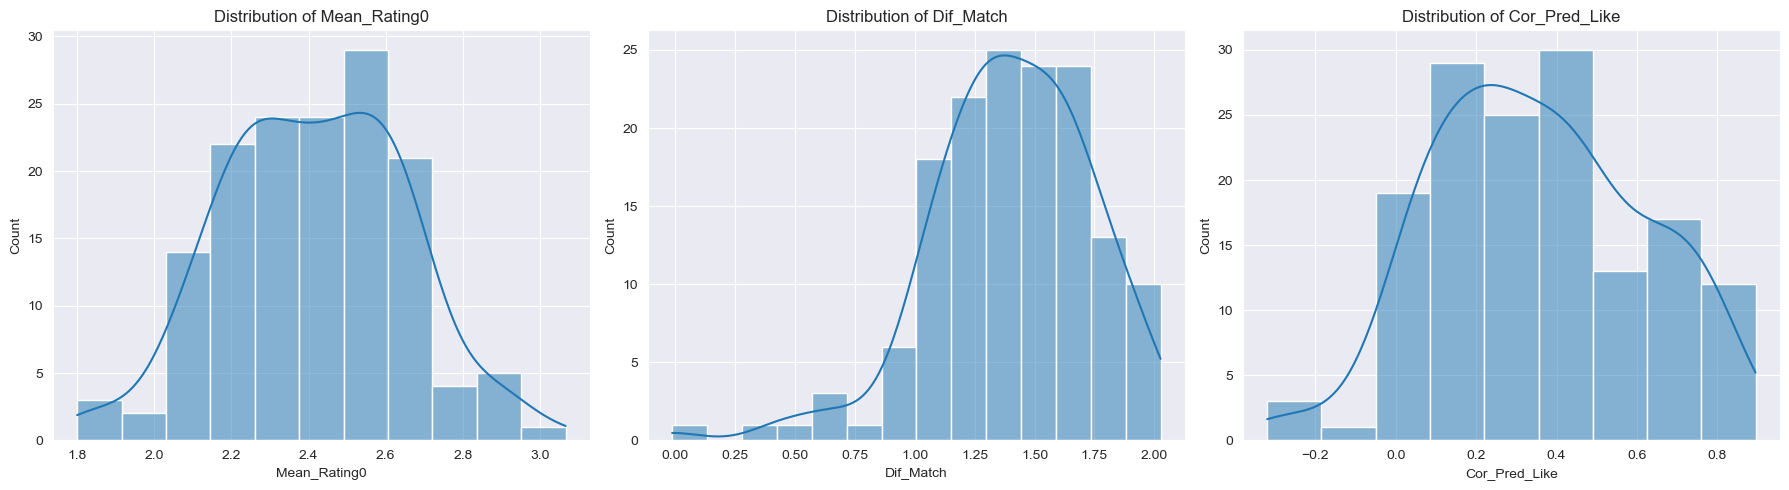

In [13]:
predictive_plots.plot_distributions(baseline)


#### Correlation of variables

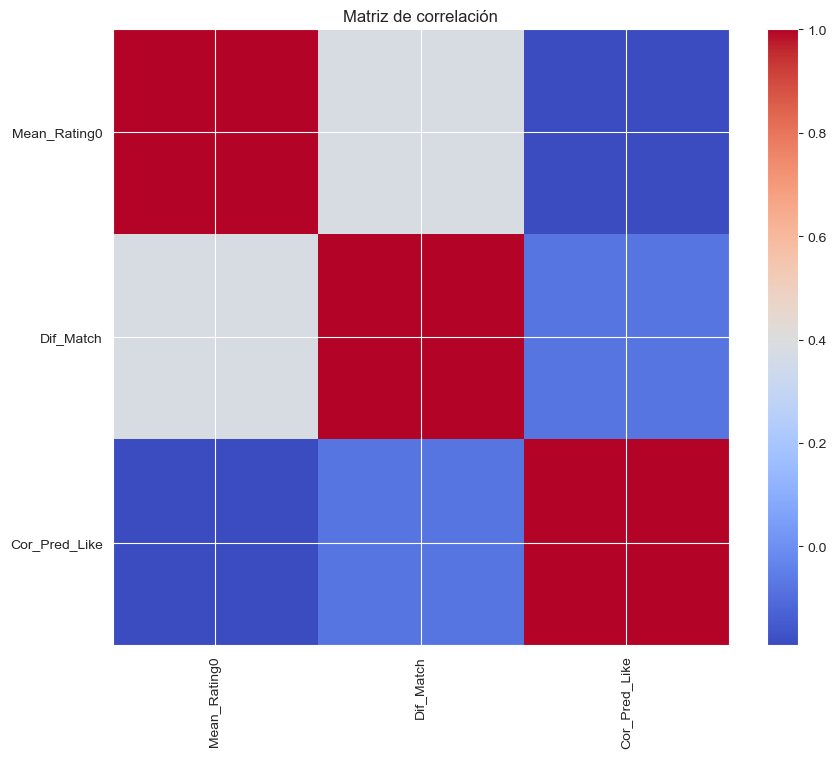

In [14]:
predictive_plots.plot_correlation(baseline)


### Clustering Baseline

In [15]:
#Normalization
scaler = StandardScaler()
scaled_data = scaler.fit_transform(baseline.drop("Subject",axis=1))
scaled_df = pd.DataFrame(scaled_data)

#### Hierarchical

In [16]:
silhouette = []
db = []
for n in range(2,20):
    data_clusters = predictive_clustering.clustering(scaled_df,AgglomerativeClustering,{'n_clusters':n,'linkage':"complete"},fit=True)
    silhouette.append(silhouette_score(scaled_df, data_clusters))
    db.append(davies_bouldin_score(scaled_df, data_clusters))


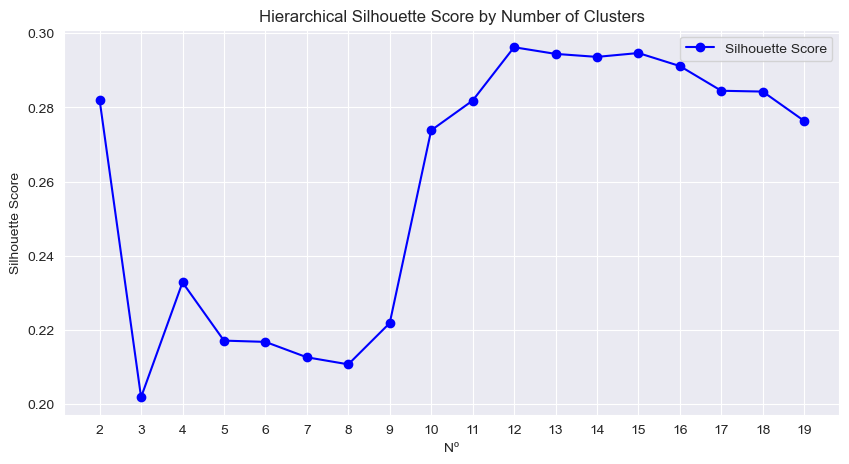

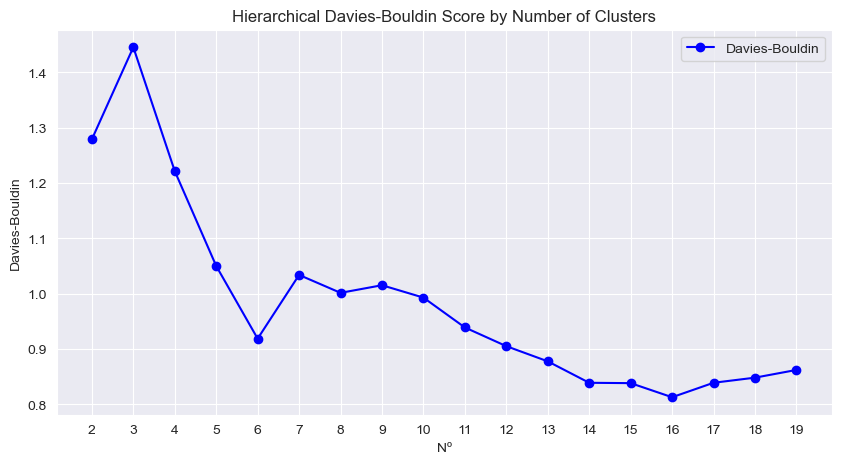

In [17]:
cluster_range = range(2, 20)
label = 'Silhouette Score'
title = 'Hierarchical Silhouette Score by Number of Clusters'
predictive_plots.metrics_plot(cluster_range, silhouette,label,title)

cluster_range = range(2, 20)
label = 'Davies-Bouldin'
title = 'Hierarchical Davies-Bouldin Score by Number of Clusters'
predictive_plots.metrics_plot(cluster_range, db,label,title)


In [18]:
for n in range(2,7):
    data_clusters = predictive_clustering.clustering(scaled_df,AgglomerativeClustering,{'n_clusters':n,'linkage':"complete"},fit=True)
    df_cluster = pd.concat([baseline["Subject"].copy(),pd.Series(data_clusters)],axis=1)
    df_cluster.columns = ["Subject","clusters"]
    name_output = f"baseline_hierarchical_{n}_clusters.docx"
    new_data = pd.merge(scales.copy(), df_cluster.copy(), right_on='Subject', left_on='EPRIME_CODE')
    new_data.drop("Subject", axis=1, inplace=True)
    df = utils.filter_data(new_data)
    utils.create_word(df, list_metrics, name_output)
    
    name_output = f"baseline_hierarchical_{n}_clusters_tasks.docx"
    new_data = pd.merge(mean_data.copy(), df_cluster.copy(), right_on='Subject', left_on='Subject ID')
    new_data.drop("Subject", axis=1, inplace=True)
    utils.create_word(new_data, list_emotions, name_output)

    
    
    output_name = f'Clusters_CountData/baseline_hierarchical_{n}_clusters.xlsx'
    utils.export_clusters_df(df_cluster.copy(),output_name)
    
    


#### OPTICS

In [19]:
silhouette = []
db = []
for n in range(4,10):
    
    data_clusters = predictive_clustering.clustering(scaled_df,OPTICS,{"min_samples":n, "metric":"euclidean", "algorithm":"auto"},fit=True)
    
    
    copy_df = scaled_data.copy()
    copy_df = pd.DataFrame(copy_df)

    copy_df["clusters"] = data_clusters
    copy_df = copy_df[copy_df["clusters"] != -1]
    silhouette.append(silhouette_score(copy_df.drop("clusters",axis=1), copy_df["clusters"]))
    db.append(davies_bouldin_score(copy_df.drop("clusters",axis=1), copy_df["clusters"]))




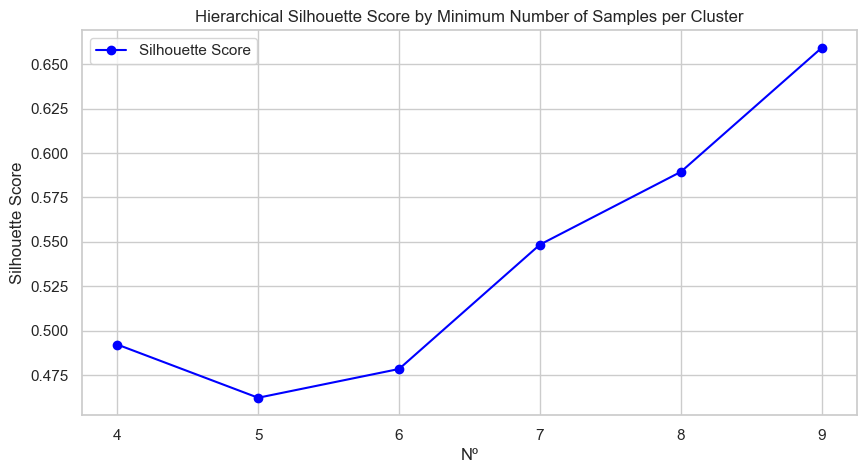

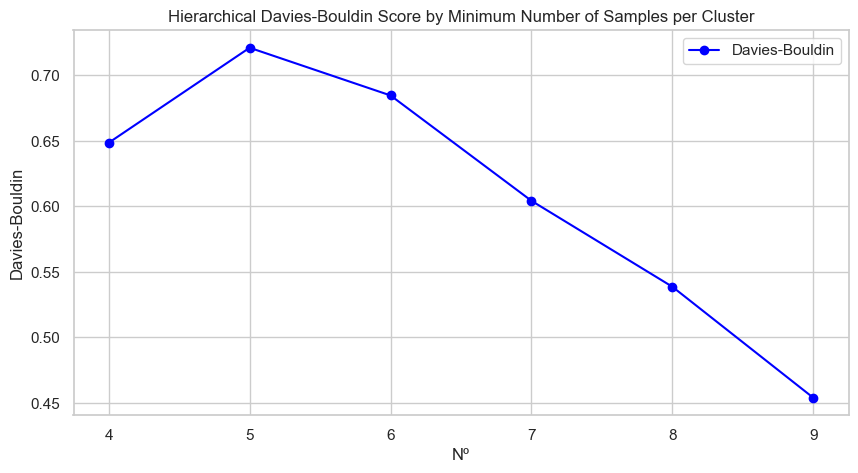

In [20]:
cluster_range = range(4, 10)
label = 'Silhouette Score'
title = 'Hierarchical Silhouette Score by Minimum Number of Samples per Cluster'
predictive_plots.metrics_plot(cluster_range, silhouette, label, title)

cluster_range = range(4, 10)
label = 'Davies-Bouldin'
title = 'Hierarchical Davies-Bouldin Score by Minimum Number of Samples per Cluster'
predictive_plots.metrics_plot(cluster_range, db, label, title)


In [21]:
new_data

,Subject ID,Happy_No_Match,Happy_Match,Sad_No_Match,Sad_Match,Fear_No_Match,Fear_Match,Mean_Rating0,Dif_Match,Cor_Pred_Like,clusters
0,PREDWELL_RETOS-1-1,1.500000,3.888889,2.166667,3.555556,2.000000,3.222222,2.888889,1.614379,0.113495,1
1,PREDWELL_RETOS-10-1,1.333333,3.333333,1.833333,2.555556,2.333333,3.111111,2.533333,1.117647,0.214781,2
2,PREDWELL_RETOS-1001-1,1.500000,3.888889,1.666667,2.888889,2.000000,3.000000,2.644444,1.494553,0.336312,0
3,PREDWELL_RETOS-1002-1,1.333333,3.777778,2.000000,3.000000,2.333333,3.000000,2.711111,1.318083,0.450822,0
4,PREDWELL_RETOS-1003-1,1.000000,3.333333,1.333333,2.777778,1.666667,2.222222,2.200000,1.424837,0.073526,2
...,...,...,...,...,...,...,...,...,...,...,...
144,PREDWELL_RETOS-5-1,1.333333,3.000000,1.666667,3.222222,1.833333,2.444444,2.377778,1.300654,0.225374,2
145,PREDWELL_RETOS-6-1,1.166667,3.222222,1.500000,2.222222,2.000000,2.777778,2.266667,1.152505,0.499722,0
146,PREDWELL_RETOS-7-1,1.000000,3.222222,1.833333,3.000000,2.000000,2.777778,2.444444,1.352941,0.426911,0
147,PREDWELL_RETOS-8-1,1.000000,3.111111,2.000000,3.111111,2.666667,2.777778,2.555556,1.117647,0.186173,2


In [22]:
for n in range(4,8):
    data_clusters = predictive_clustering.clustering(scaled_df,OPTICS,{"min_samples":n, "metric":"euclidean", "algorithm":"auto"},fit=True)
    df_cluster = pd.concat([baseline["Subject"].copy(),pd.Series(data_clusters)],axis=1)
    df_cluster.columns = ["Subject","clusters"]
    name_output = f"baseline_optics_{n}_clusters.docx"
    new_data = pd.merge(scales.copy(), df_cluster.copy(), right_on='Subject', left_on='EPRIME_CODE')
    new_data.drop("Subject", axis=1, inplace=True)
    df = utils.filter_data(new_data)
    utils.create_word(df, list_metrics, name_output)
    
    name_output = f"baseline_optics_{n}_clusters_tasks.docx"
    new_data = pd.merge(mean_data.copy(), df_cluster.copy(), right_on='Subject', left_on='Subject ID')
    new_data.drop("Subject", axis=1, inplace=True)
    df = new_data[new_data["clusters"]>=0]

    utils.create_word(df, list_emotions, name_output)
    
    
    output_name = f'Clusters_CountData/baseline_optics_{n}_per_clusters.xlsx'
    utils.export_clusters_df(df_cluster.copy(),output_name)

## Prediction on Rating0 on RETOS & BEBRASK on Count Dataset

In [23]:
data = pd.read_excel("RETOS_BEBRASK_Rating0_count.xlsx")
data

,Subject,Count_Happy_1_1,Count_Happy_1_2,Count_Happy_1_3,Count_Happy_1_4,Count_Happy_0_1,Count_Happy_0_2,Count_Happy_0_3,Count_Happy_0_4,Count_Sad_1_1,...,Count_Sad_0_3,Count_Sad_0_4,Count_Fear_1_1,Count_Fear_1_2,Count_Fear_1_3,Count_Fear_1_4,Count_Fear_0_1,Count_Fear_0_2,Count_Fear_0_3,Count_Fear_0_4
0,PREDWELL_RETOS-1-1,0,0,1,8,5,0,0,1,0,...,2,1,0,3,1,5,3,1,1,1
1,PREDWELL_RETOS-10-1,0,1,4,4,4,2,0,0,0,...,1,0,1,1,3,4,1,3,1,1
2,PREDWELL_RETOS-101-1,0,1,2,6,5,1,0,0,1,...,1,0,2,1,3,3,5,1,0,0
3,PREDWELL_RETOS-102-1,1,0,4,4,6,0,0,0,1,...,0,3,0,2,3,4,4,2,0,0
4,PREDWELL_RETOS-103-1,0,1,1,7,5,1,0,0,0,...,1,0,3,2,3,1,3,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,PREDWELL_RETOS-1124-1,0,3,2,4,3,3,0,0,2,...,0,0,1,3,5,0,5,0,1,0
145,PREDWELL_RETOS-1125-1,0,0,3,6,5,1,0,0,0,...,1,0,1,3,2,3,2,3,1,0
146,PREDWELL_RETOS-1126-1,0,1,2,6,6,0,0,0,2,...,2,0,0,3,1,5,3,0,1,2
147,PREDWELL_RETOS-1127-1,0,0,2,7,4,2,0,0,0,...,1,0,1,3,1,4,2,3,1,0


#### Distribution of variables

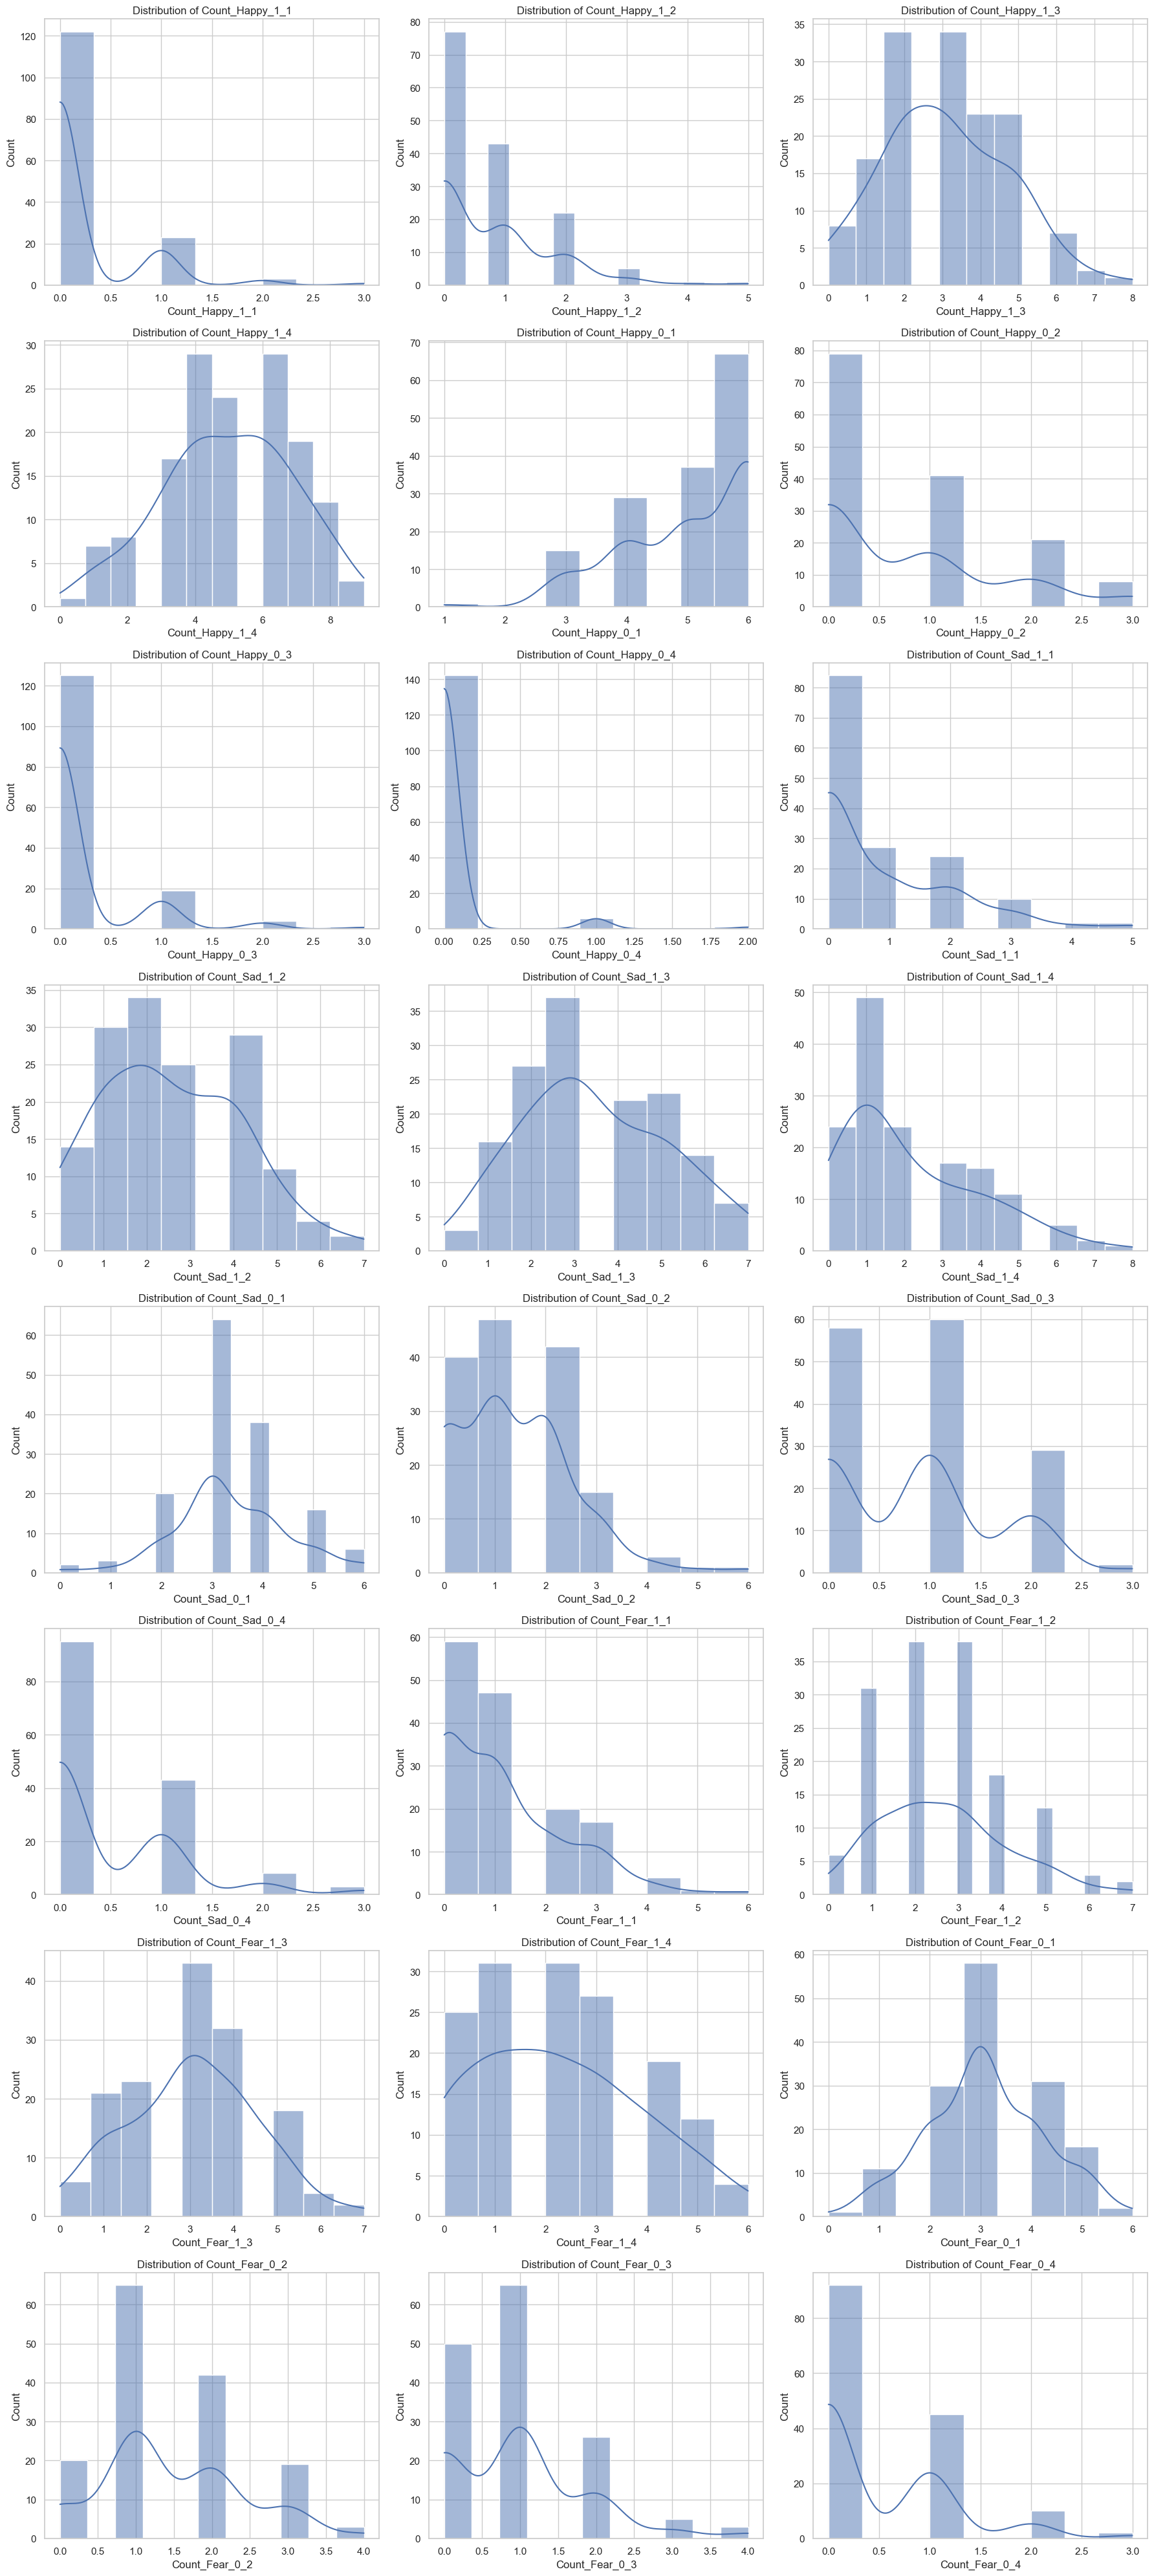

In [24]:
predictive_plots.plot_distributions(data)

#### Correlation of variables


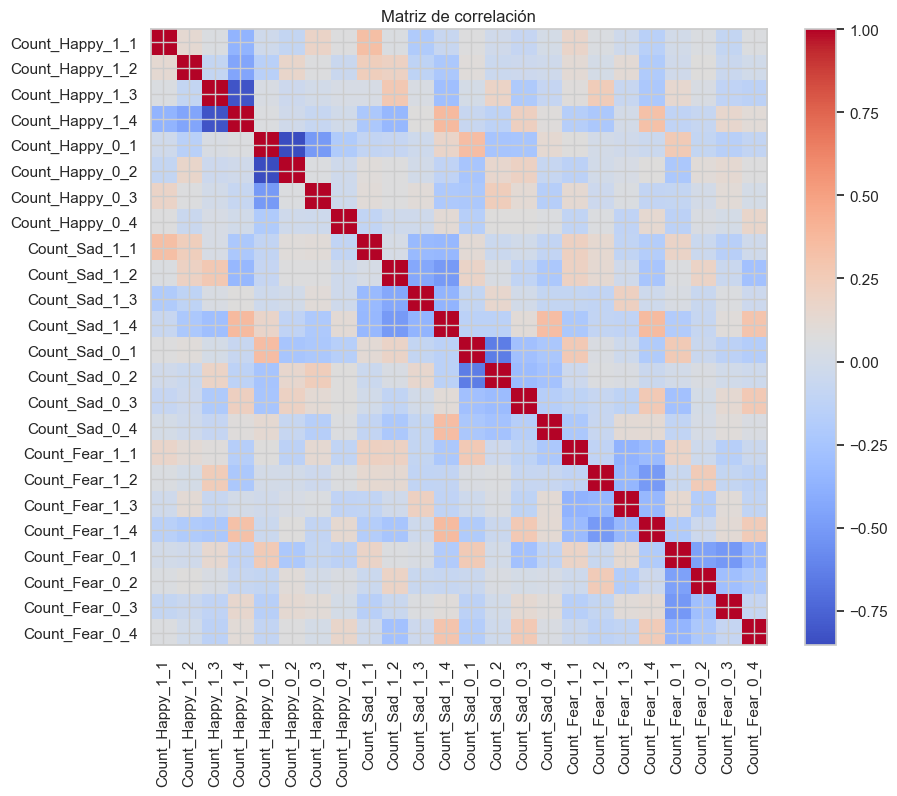

In [25]:
predictive_plots.plot_correlation(data)


In general, positive correlations can be observed between different emotions that maintain the same match and have the same score. Negative correlations are observed between the count variables of the same emotion and the same match (the 4x4 matrices that are generated around the diagonal).

### PLN-PCA Transformation

Given that count data follows a Poisson process, we can use Poisson-lognormal transformation to have normal data. As the count data matrix is quite sparse, we can also use the zero inflated formula that takes into account the higher amount of 0 in the dataset when transforming. 

In [26]:
data = data.sort_values(by='Subject').reset_index(drop=True)

In [27]:
from pyPLNmodels.models import PlnPCAcollection, Pln, ZIPln

In [28]:
tasks = {}
tasks["counts"] = data.drop(["Subject"],axis=1).values
tasks["correlation"] = baseline["Cor_Pred_Like"].values
tasks["Dif_Match"] = baseline["Dif_Match"]


zi = ZIPln(endog = tasks["counts"],exog=baseline[["Cor_Pred_Like","Dif_Match"]])
zi.fit()
transformed_data = zi.transform()
transformed_data = np.array(transformed_data)
df_transformed_data = pd.DataFrame(transformed_data)


scaler = StandardScaler()
scaled_transformed_data = scaler.fit_transform(df_transformed_data)
scaled_transformed_df = pd.DataFrame(scaled_transformed_data)


scaled_transformed_df.insert(0,"Subject",data["Subject"].copy())

Setting the offsets to zero
Fitting a ZIPln model with full covariance model and zero-inflation.
Initialization ...
Initialization finished
Tolerance 0.001 reached in 586 iterations


## Distribution of Transformed Data

In [29]:
scaled_transformed_df.columns = data.columns

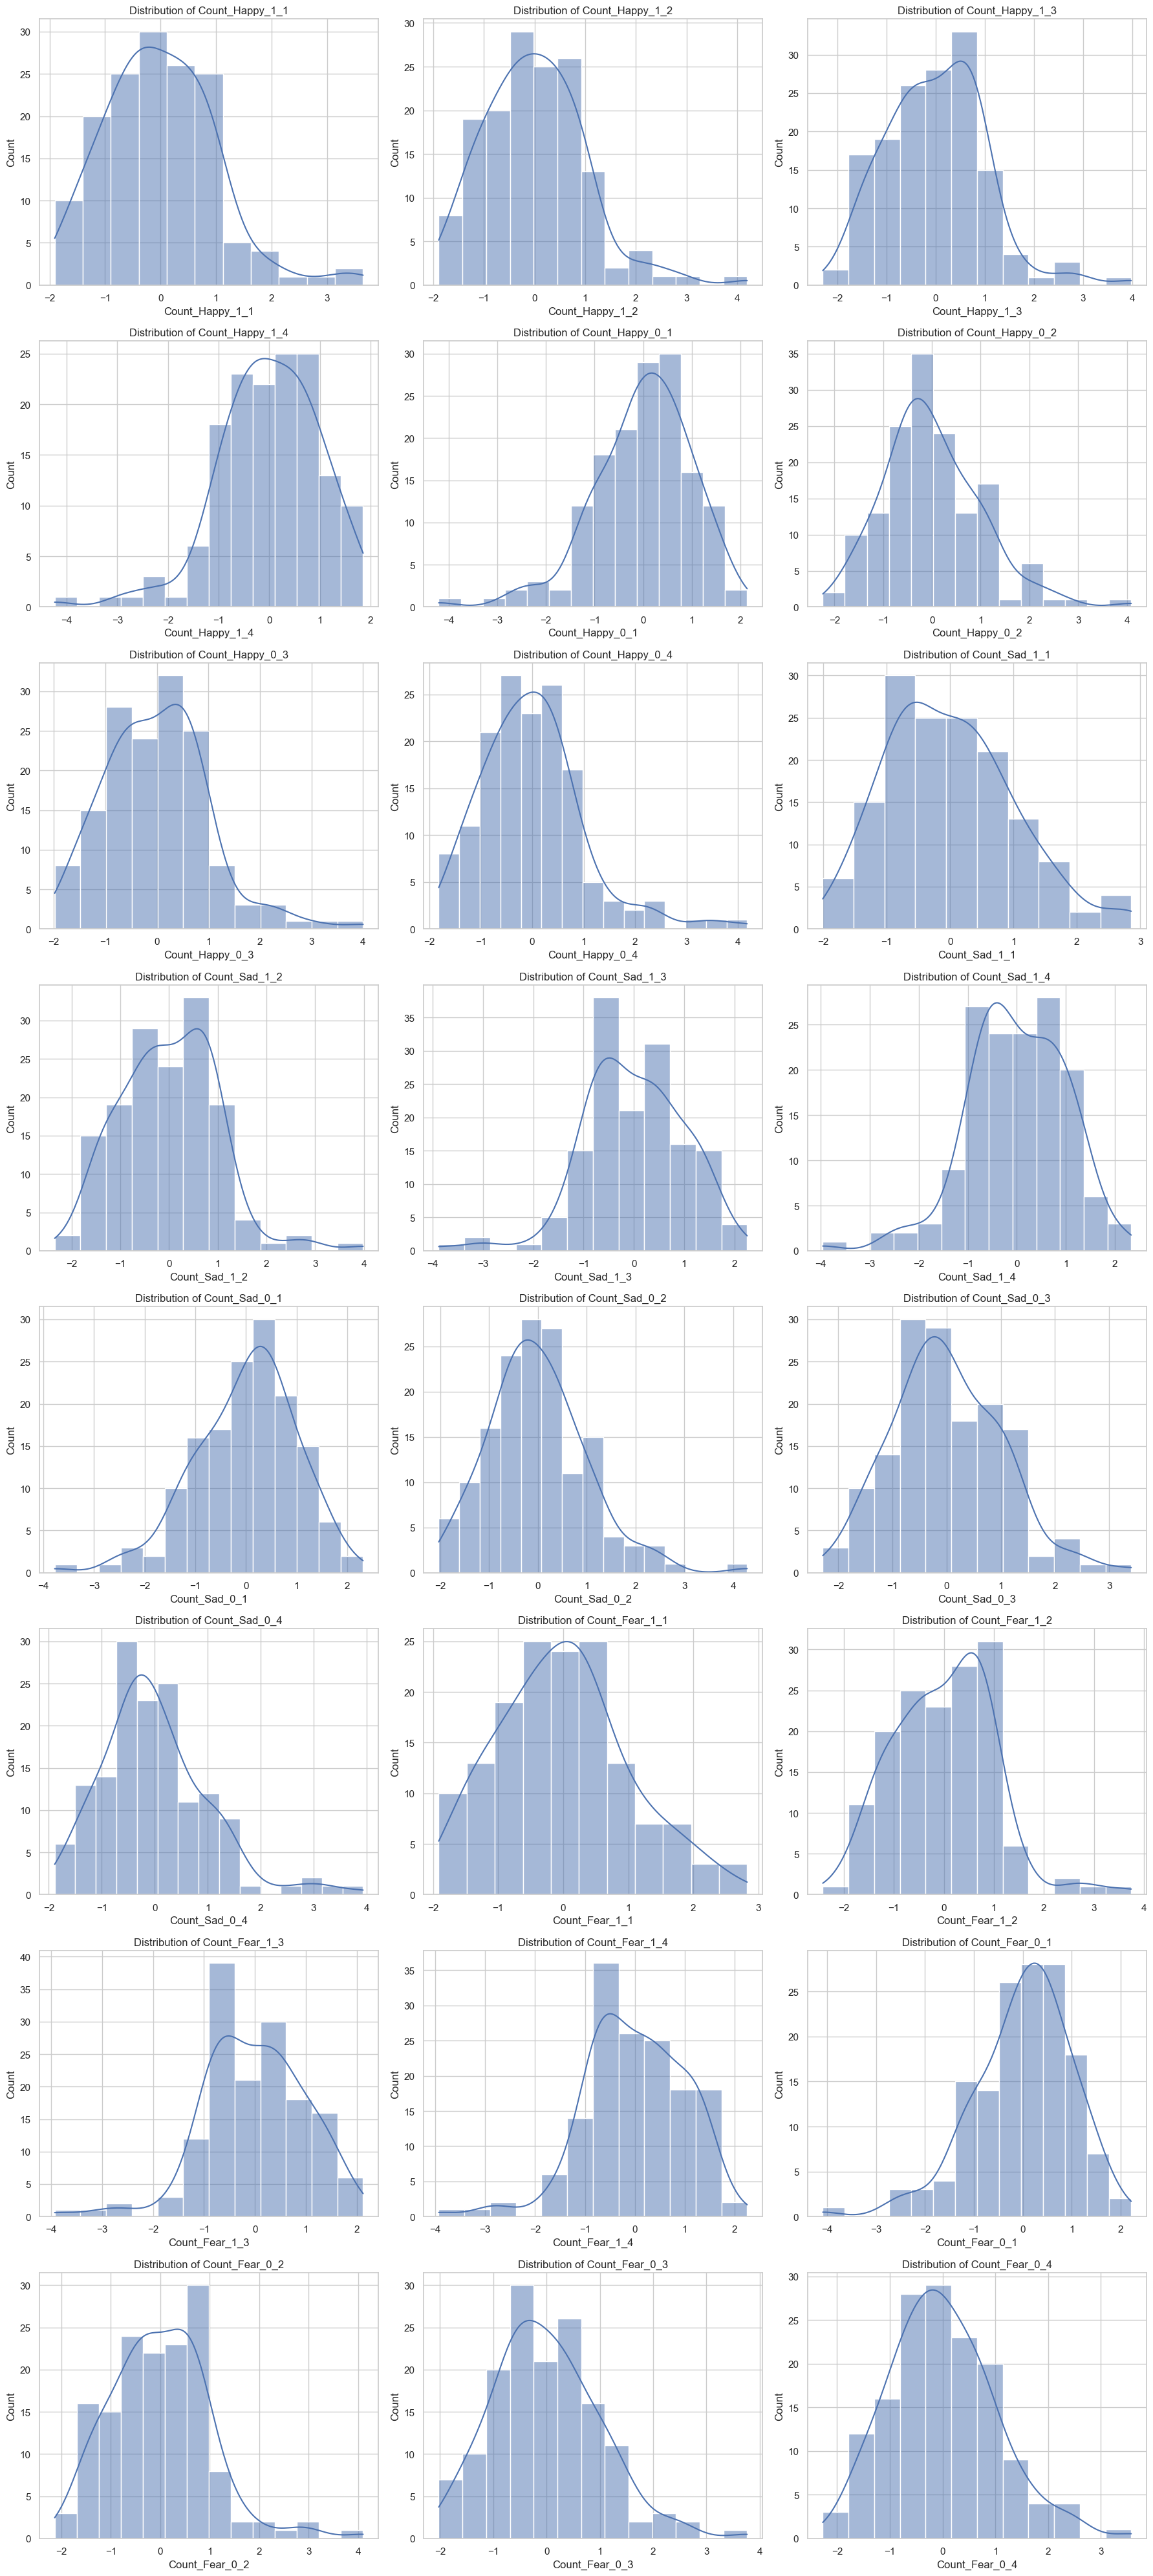

In [30]:
predictive_plots.plot_distributions(scaled_transformed_df)

#### Correlation of Transformed Data


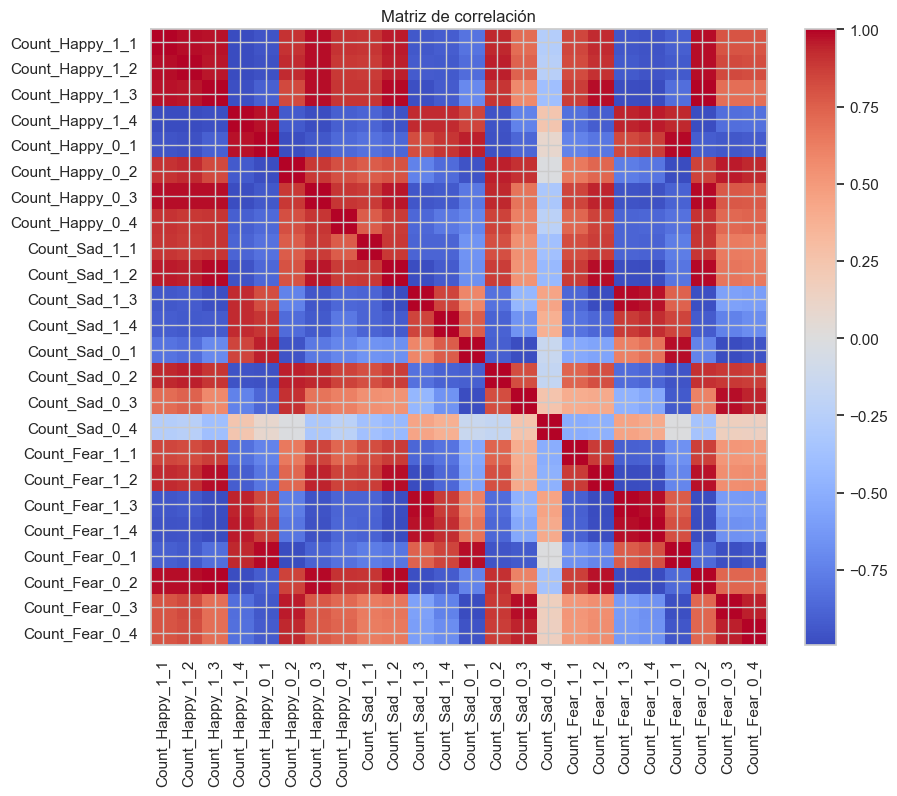

In [31]:
predictive_plots.plot_correlation(scaled_transformed_df)

## Clustering on Transformed Data

#### Hierarchical Clustering

In [32]:
silhouette = []
db = []
for n in range(2,20):
    data_clusters = predictive_clustering.clustering(scaled_transformed_df.drop("Subject",axis=1),AgglomerativeClustering,{'n_clusters':n,'linkage':"complete"},fit=True)
    silhouette.append(silhouette_score(scaled_transformed_df.drop("Subject",axis=1), data_clusters))
    db.append(davies_bouldin_score(scaled_transformed_df.drop("Subject",axis=1), data_clusters))


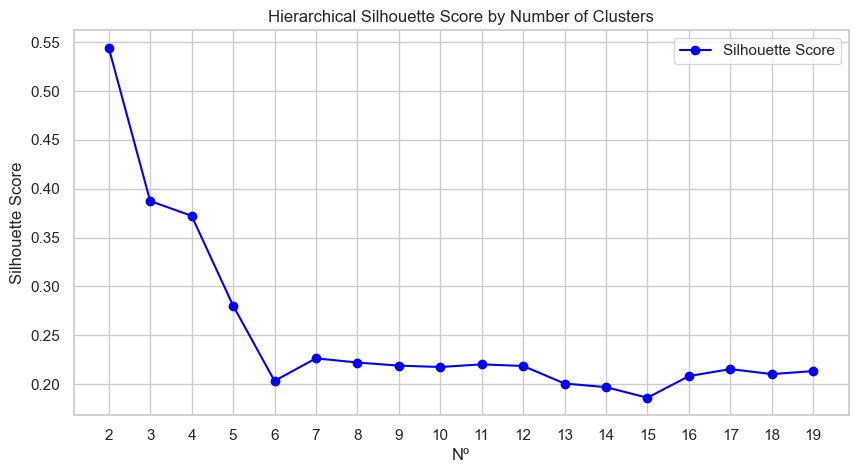

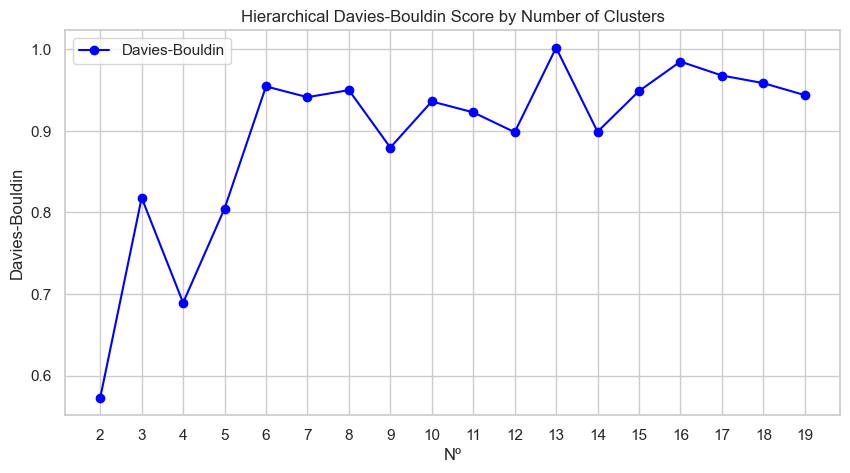

In [33]:
cluster_range = range(2, 20)
label = 'Silhouette Score'
title = 'Hierarchical Silhouette Score by Number of Clusters'
predictive_plots.metrics_plot(cluster_range, silhouette,label,title)

cluster_range = range(2, 20)
label = 'Davies-Bouldin'
title = 'Hierarchical Davies-Bouldin Score by Number of Clusters'
predictive_plots.metrics_plot(cluster_range, db,label,title)


In [34]:
for n in range(2,7):
    data_clusters = predictive_clustering.clustering(scaled_transformed_df.drop("Subject",axis=1),AgglomerativeClustering,{'n_clusters':n,'linkage':"complete"},fit=True)
    df_cluster = pd.concat([scaled_transformed_df["Subject"].copy(),pd.Series(data_clusters)],axis=1)
    df_cluster.columns = ["Subject","clusters"]
    name_output = f"count_hierarchical_{n}_clusters.docx"
    new_data = pd.merge(scales.copy(), df_cluster.copy(), right_on='Subject', left_on='EPRIME_CODE')
    new_data.drop("Subject", axis=1, inplace=True)
    df = utils.filter_data(new_data)
    utils.create_word(df, list_metrics, name_output)
    
    
    name_output = f"count_hierarchical_{n}_clusters_tasks.docx"
    new_data = pd.merge(mean_data.copy(), df_cluster.copy(), right_on='Subject', left_on='Subject ID')
    new_data.drop("Subject", axis=1, inplace=True)
    utils.create_word(new_data, list_emotions, name_output)

    output_name = f'Clusters_CountData/count_hierarchical_{n}_clusters.xlsx'
    utils.export_clusters_df(df_cluster.copy(),output_name)
    
    


#### OPTICS Clustering

In [35]:
silhouette = []
db = []
for n in range(2,8):
    
    data_clusters = predictive_clustering.clustering(scaled_transformed_df.drop("Subject",axis=1),OPTICS,{"min_samples":n, "metric":"euclidean", "algorithm":"auto"},fit=True)
    
    
    copy_df = scaled_transformed_df.drop("Subject",axis=1).copy()
    copy_df = pd.DataFrame(copy_df)

    copy_df["clusters"] = data_clusters
    copy_df = copy_df[copy_df["clusters"] != -1]
    silhouette.append(silhouette_score(copy_df.drop("clusters",axis=1), copy_df["clusters"]))
    db.append(davies_bouldin_score(copy_df.drop("clusters",axis=1), copy_df["clusters"]))


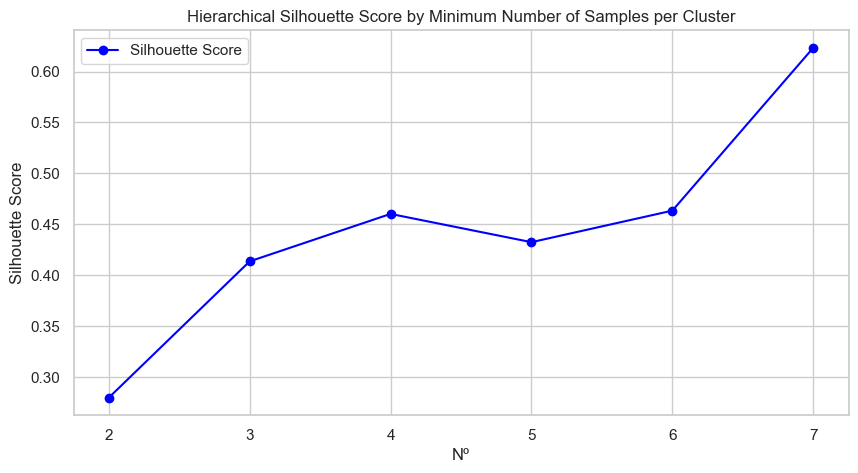

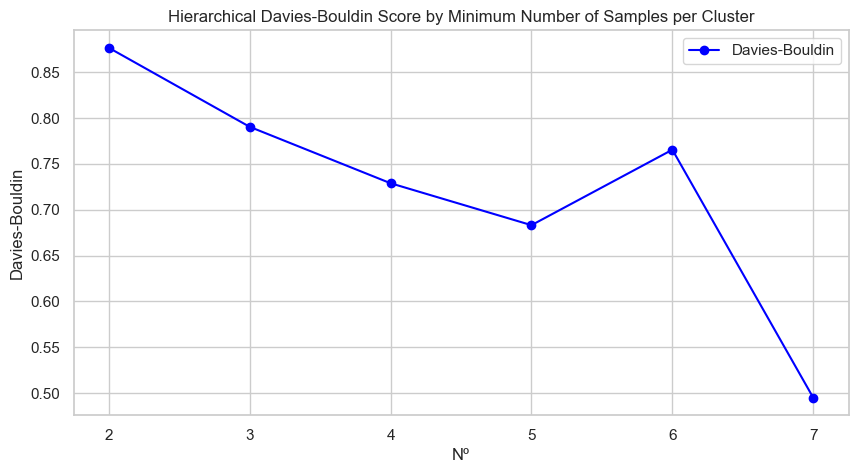

In [36]:

cluster_range = range(2, 8)
label = 'Silhouette Score'
title = 'Hierarchical Silhouette Score by Minimum Number of Samples per Cluster'
predictive_plots.metrics_plot(cluster_range, silhouette, label, title)

cluster_range = range(2, 8)
label = 'Davies-Bouldin'
title = 'Hierarchical Davies-Bouldin Score by Minimum Number of Samples per Cluster'
predictive_plots.metrics_plot(cluster_range, db, label, title)


In [37]:
for n in range(4,8):
    data_clusters = predictive_clustering.clustering(scaled_transformed_df.drop("Subject",axis=1),OPTICS,{"min_samples":n, "metric":"euclidean", "algorithm":"auto"},fit=True)
    df_cluster = pd.concat([scaled_transformed_df["Subject"].copy(),pd.Series(data_clusters)],axis=1)
    df_cluster.columns = ["Subject","clusters"]
    name_output = f"count_optics_{n}_clusters.docx"
    new_data = pd.merge(scales.copy(), df_cluster.copy(), right_on='Subject', left_on='EPRIME_CODE')
    new_data.drop("Subject", axis=1, inplace=True)
    df = utils.filter_data(new_data)
    utils.create_word(df, list_metrics, name_output)
    
    
    name_output = f"count_optics_{n}_clusters_tasks.docx"
    new_data = pd.merge(mean_data.copy(), df_cluster.copy(), right_on='Subject', left_on='Subject ID')
    new_data.drop("Subject", axis=1, inplace=True)
    df = new_data[new_data["clusters"]>=0]

    utils.create_word(df, list_emotions, name_output)

    
    output_name = f'Clusters_CountData/count_optics_{n}_per_clusters.xlsx'
    utils.export_clusters_df(df_cluster.copy(),output_name)

### Generating the Ordered Documents for the best clusters of each type

#### Baseline Hierarchical

In [43]:
data_clusters = predictive_clustering.clustering(scaled_df,AgglomerativeClustering,{'n_clusters':6,'linkage':"complete"},fit=True)
df_cluster = pd.concat([baseline["Subject"].copy(),pd.Series(data_clusters)],axis=1)
df_cluster.columns = ["Subject","clusters"]

#AVERAGE RATING0

name_output = f"baseline_hierarchical_{6}_clusters_avg_rating.docx"
new_data = pd.merge(scales.copy(), df_cluster.copy(), right_on='Subject', left_on='EPRIME_CODE')
new_data.drop("Subject", axis=1, inplace=True)
df = utils.filter_data(new_data)
utils.create_word(df, list_metrics, name_output,df_scales= scales,cluster_order = [1,0,2,4,3,5])

#CORRELATION

name_output = f"baseline_hierarchical_{6}_clusters_correlation.docx"
new_data = pd.merge(scales.copy(), df_cluster.copy(), right_on='Subject', left_on='EPRIME_CODE')
new_data.drop("Subject", axis=1, inplace=True)
df = utils.filter_data(new_data)
utils.create_word(df, list_metrics, name_output,df_scales= scales,cluster_order = [0,4,3,1,2,5])

#DIFFERENCE MATCH

name_output = f"baseline_hierarchical_{6}_clusters_dif_match.docx"
new_data = pd.merge(scales.copy(), df_cluster.copy(), right_on='Subject', left_on='EPRIME_CODE')
new_data.drop("Subject", axis=1, inplace=True)
df = utils.filter_data(new_data)
utils.create_word(df, list_metrics, name_output,df_scales= scales,cluster_order = [1,0,3,2,4,5])

#### Baseline OPTICS

In [44]:
data_clusters = predictive_clustering.clustering(scaled_df,OPTICS,{"min_samples":6, "metric":"euclidean", "algorithm":"auto"},fit=True)
df_cluster = pd.concat([baseline["Subject"].copy(),pd.Series(data_clusters)],axis=1)
df_cluster.columns = ["Subject","clusters"]

#AVERAGE RATING0

name_output = f"baseline_optics_{6}_clusters_avg_rating.docx"
new_data = pd.merge(scales.copy(), df_cluster.copy(), right_on='Subject', left_on='EPRIME_CODE')
new_data.drop("Subject", axis=1, inplace=True)
df = utils.filter_data(new_data)
utils.create_word(df, list_metrics, name_output,df_scales= scales,cluster_order = [1,0,2,5,3,6,4])

#CORRELATION

name_output = f"baseline_optics_{6}_clusters_correlation.docx"
new_data = pd.merge(scales.copy(), df_cluster.copy(), right_on='Subject', left_on='EPRIME_CODE')
new_data.drop("Subject", axis=1, inplace=True)
df = utils.filter_data(new_data)
utils.create_word(df, list_metrics, name_output,df_scales= scales,cluster_order = [5,3,1,2,4,0,6])

#DIFFERENCE MATCH

name_output = f"baseline_optics_{6}_clusters_dif_match.docx"
new_data = pd.merge(scales.copy(), df_cluster.copy(), right_on='Subject', left_on='EPRIME_CODE')
new_data.drop("Subject", axis=1, inplace=True)
df = utils.filter_data(new_data)
utils.create_word(df, list_metrics, name_output,df_scales= scales,cluster_order = [0,5,1,6,3,2,4])

#### Count Hierarchical

In [45]:
data_clusters = predictive_clustering.clustering(scaled_transformed_df.drop("Subject",axis=1),AgglomerativeClustering,{'n_clusters':6,'linkage':"complete"},fit=True)
df_cluster = pd.concat([scaled_transformed_df["Subject"].copy(),pd.Series(data_clusters)],axis=1)
df_cluster.columns = ["Subject","clusters"]


#AVERAGE HAPPY_0

name_output = f"count_hierarchical_{6}_clusters_happy_0.docx"
new_data = pd.merge(scales.copy(), df_cluster.copy(), right_on='Subject', left_on='EPRIME_CODE')
new_data.drop("Subject", axis=1, inplace=True)
df = utils.filter_data(new_data)
utils.create_word(df, list_metrics, name_output,df_scales= scales, cluster_order=[1, 0, 5, 2, 4, 3])

#AVERAGE HAPPY_1

name_output = f"count_hierarchical_{6}_clusters_happy_1.docx"
new_data = pd.merge(scales.copy(), df_cluster.copy(), right_on='Subject', left_on='EPRIME_CODE')
new_data.drop("Subject", axis=1, inplace=True)
df = utils.filter_data(new_data)
utils.create_word(df, list_metrics, name_output,df_scales= scales, cluster_order=[4, 2, 0, 5, 1, 3])

#AVERAGE SAD_0

name_output = f"count_hierarchical_{6}_clusters_sad_0.docx"
new_data = pd.merge(scales.copy(), df_cluster.copy(), right_on='Subject', left_on='EPRIME_CODE')
new_data.drop("Subject", axis=1, inplace=True)
df = utils.filter_data(new_data)
utils.create_word(df, list_metrics, name_output,df_scales= scales, cluster_order=[1, 0, 2, 4, 5, 3])

#AVERAGE SAD_1

name_output = f"count_hierarchical_{6}_clusters_sad_1.docx"
new_data = pd.merge(scales.copy(), df_cluster.copy(), right_on='Subject', left_on='EPRIME_CODE')
new_data.drop("Subject", axis=1, inplace=True)
df = utils.filter_data(new_data)
utils.create_word(df, list_metrics, name_output,df_scales= scales, cluster_order=[4, 2, 0, 5, 1, 3])

#AVERAGE FEAR_0

name_output = f"count_hierarchical_{6}_clusters_fear_0.docx"
new_data = pd.merge(scales.copy(), df_cluster.copy(), right_on='Subject', left_on='EPRIME_CODE')
new_data.drop("Subject", axis=1, inplace=True)
df = utils.filter_data(new_data)
utils.create_word(df, list_metrics, name_output,df_scales= scales, cluster_order=[1, 0, 2, 5, 4, 3])

#AVERAGE FEAR_1
name_output = f"count_hierarchical_{6}_clusters_fear_1.docx"
new_data = pd.merge(scales.copy(), df_cluster.copy(), right_on='Subject', left_on='EPRIME_CODE')
new_data.drop("Subject", axis=1, inplace=True)
df = utils.filter_data(new_data)
utils.create_word(df, list_metrics, name_output,df_scales= scales, cluster_order=[2, 4, 0, 5, 1, 3])

#CORRELATION

name_output = f"count_hierarchical_{6}_clusters_correlation.docx"
new_data = pd.merge(scales.copy(), df_cluster.copy(), right_on='Subject', left_on='EPRIME_CODE')
new_data.drop("Subject", axis=1, inplace=True)
df = utils.filter_data(new_data)
utils.create_word(df, list_metrics, name_output,df_scales= scales, cluster_order=[5, 2, 1, 4, 0, 3])

#AVERAGE RATING0

name_output = f"count_hierarchical_{6}_clusters_dif_match.docx"
new_data = pd.merge(scales.copy(), df_cluster.copy(), right_on='Subject', left_on='EPRIME_CODE')
new_data.drop("Subject", axis=1, inplace=True)
df = utils.filter_data(new_data)
utils.create_word(df, list_metrics, name_output,df_scales= scales, cluster_order=[4, 2, 5, 0, 1, 3])


#### Count OPTICS

In [46]:
data_clusters = predictive_clustering.clustering(scaled_transformed_df.drop("Subject",axis=1),OPTICS,{"min_samples":6, "metric":"euclidean", "algorithm":"auto"},fit=True)
df_cluster = pd.concat([scaled_transformed_df["Subject"].copy(),pd.Series(data_clusters)],axis=1)
df_cluster.columns = ["Subject","clusters"]


#AVERAGE HAPPY_0

name_output = f"count_optics_{6}_clusters_happy_0.docx"
new_data = pd.merge(scales.copy(), df_cluster.copy(), right_on='Subject', left_on='EPRIME_CODE')
new_data.drop("Subject", axis=1, inplace=True)
df = utils.filter_data(new_data)
utils.create_word(df, list_metrics, name_output,df_scales= scales, cluster_order=[2, 1, 0, 3, 4])

#AVERAGE HAPPY_1

name_output = f"count_optics_{6}_clusters_happy_1.docx"
new_data = pd.merge(scales.copy(), df_cluster.copy(), right_on='Subject', left_on='EPRIME_CODE')
new_data.drop("Subject", axis=1, inplace=True)
df = utils.filter_data(new_data)
utils.create_word(df, list_metrics, name_output,df_scales= scales, cluster_order=[0, 4, 3, 1, 2])

#AVERAGE SAD_0

name_output = f"count_optics_{6}_clusters_sad_0.docx"
new_data = pd.merge(scales.copy(), df_cluster.copy(), right_on='Subject', left_on='EPRIME_CODE')
new_data.drop("Subject", axis=1, inplace=True)
df = utils.filter_data(new_data)
utils.create_word(df, list_metrics, name_output,df_scales= scales, cluster_order=[2, 1, 0, 3, 4])

#AVERAGE SAD_1

name_output = f"count_optics_{6}_clusters_sad_1.docx"
new_data = pd.merge(scales.copy(), df_cluster.copy(), right_on='Subject', left_on='EPRIME_CODE')
new_data.drop("Subject", axis=1, inplace=True)
df = utils.filter_data(new_data)
utils.create_word(df, list_metrics, name_output,df_scales= scales, cluster_order=[4, 0, 3, 1, 2])

#AVERAGE FEAR_0

name_output = f"count_optics_{6}_clusters_fear_0.docx"
new_data = pd.merge(scales.copy(), df_cluster.copy(), right_on='Subject', left_on='EPRIME_CODE')
new_data.drop("Subject", axis=1, inplace=True)
df = utils.filter_data(new_data)
utils.create_word(df, list_metrics, name_output,df_scales= scales, cluster_order=[2, 0, 1, 3, 4])

#AVERAGE FEAR_1
name_output = f"count_optics_{6}_clusters_fear_1.docx"
new_data = pd.merge(scales.copy(), df_cluster.copy(), right_on='Subject', left_on='EPRIME_CODE')
new_data.drop("Subject", axis=1, inplace=True)
df = utils.filter_data(new_data)
utils.create_word(df, list_metrics, name_output,df_scales= scales, cluster_order=[0, 4, 3, 1, 2])

#CORRELATION

name_output = f"count_optics_{6}_clusters_correlation.docx"
new_data = pd.merge(scales.copy(), df_cluster.copy(), right_on='Subject', left_on='EPRIME_CODE')
new_data.drop("Subject", axis=1, inplace=True)
df = utils.filter_data(new_data)
utils.create_word(df, list_metrics, name_output,df_scales= scales, cluster_order=[3, 1, 4, 2, 0])

#AVERAGE RATING0

name_output = f"count_optics_{6}_clusters_dif_match.docx"
new_data = pd.merge(scales.copy(), df_cluster.copy(), right_on='Subject', left_on='EPRIME_CODE')
new_data.drop("Subject", axis=1, inplace=True)
df = utils.filter_data(new_data)
utils.create_word(df, list_metrics, name_output,df_scales= scales, cluster_order=[4, 0, 3, 1, 2])

